<a href="https://colab.research.google.com/github/adithyamauryakr/pytorchtutorials/blob/main/graph_nn_stuff/gcn_torch_geometric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.8 MB/s eta 0:00:00


In [13]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import math

import networkx as nx

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch_geometric
from torch_geometric.datasets import StochasticBlockModelDataset
from torch_geometric.utils import to_networkx, to_dense_adj
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils import to_networkx

In [5]:
num_nodes_per_class = 100
num_nodes = [num_nodes_per_class]*3
edge_probs = [[0.1, 0.05, 0.03],
              [0.05, 0.1, 0.02],
              [0.02, 0.02, 0.1]]
dataset = StochasticBlockModelDataset('/content', num_nodes, edge_probs, num_channels=10, is_undirected=False)

Processing...
Done!


In [7]:
colors = cm.tab10.colors
y_colors = np.array(colors)[dataset[0].y.numpy()]

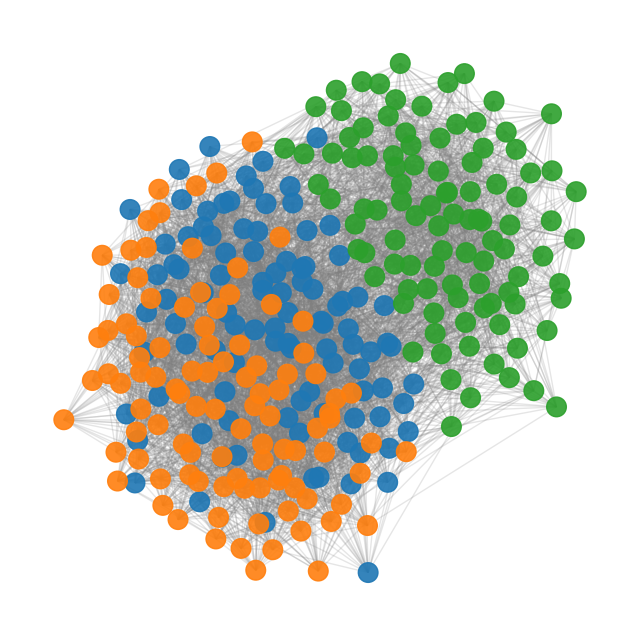

In [10]:
G = to_networkx(dataset[0], to_undirected=True)
node_pos=nx.spring_layout(G, seed=0)
plt.figure(figsize=(8,8))
plt.axis('off')
nx.draw_networkx_nodes(G,
                       pos=node_pos,
                       node_size=200,
                       node_color=y_colors,
                       alpha=0.9)

nx.draw_networkx_edges(G,
                       pos=node_pos,
                       edge_color='grey',
                       alpha=0.2)
plt.show()

In [12]:
split = RandomNodeSplit(num_val=0.1, num_test=0.1)
data = split(dataset[0])
data

Data(x=[300, 10], edge_index=[2, 4941], y=[300], train_mask=[300], val_mask=[300], test_mask=[300])

###**GCN**

In [16]:
class GraphConvolution(nn.Module):

  def __init__(self, in_features, out_features, bias=True):
    super().__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
    if bias:
      self.bias=nn.Parameter(torch.FloatTensor(out_features))
    else:
      self.register_parameter('bias', None)
    self.reset_parameters()

  def reset_parameters(self):
    stdv = 1./math.sqrt(self.weight.size(1))
    self.weight.data.uniform_(-stdv, stdv)
    if self.bias is not None:
      self.bias.data.uniform_(-stdv,stdv)

  def forward(self, input, adj):
    support = torch.mm(input, self.weight)
    output = torch.spmm(adj, support)
    if self.bias is not None:
      return output + self.bias
    else:
      return output

  def __repr__(self):
    return self.__class__.__name__+'('+str(self.in_features)+'->'+str(self.out_features)+')'

In [18]:
class GCN(nn.Module):
  def __init__(self, nfeat, nhid, nclass, dropout):
    super().__init__()

    self.gc1 = GraphConvolution(nfeat, nhid)
    self.gc2 = GraphConvolution(nhid, nclass)
    self.dropout = dropout

  def forward(self, x, adj):
    x = F.relu(self.gc1(x, adj))
    x = F.dropout(x, self.dropout, training=self.training)
    x = self.gc2(x, adj)
    return F.log_softmax(x, dim=1)

In [22]:
# training
adj = to_dense_adj(data.edge_index)[0]
# build symmetric adjacency matrix
adj = adj + adj.T.multiply(adj.T>adj) - adj.multiply(adj.T >adj)
adj = adj + torch.eye(adj.shape[0])

features = data.x
labels = data.y
idx_train = data.train_mask
idx_val = data.val_mask
idx_test = data.test_mask

In [23]:
model = GCN(nfeat = features.shape[1],
            nhid=3,
            nclass=labels.max().item()+1,
            dropout=0.5)

optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay=5e-4)

In [24]:
def accuracy(output, labels):
  preds = output.max(1)[1].type_as(labels)
  correct = preds.eq(labels).double()
  correct = correct.sum()
  return correct/len(labels)

In [26]:
loss_train_list = []
loss_val_list = []
for epoch in range(1000):
  model.train()
  optimizer.zero_grad()
  output = model(features, adj)
  loss_train = F.nll_loss(output[idx_train], labels[idx_train])
  loss_train_list.append(loss_train.item())
  acc_train = accuracy(output[idx_train], labels[idx_train])
  loss_train.backward()
  optimizer.step()

  model.eval()
  output = model(features, adj)
  loss_val = F.nll_loss(output[idx_val], labels[idx_val])
  loss_val_list.append(loss_val.item())
  acc_val = accuracy(output[idx_val], labels[idx_val])

  if epoch % 10 ==0:
    print(f'Epoch {epoch:>3} | Train Loss: {loss_train.item():.4f} | Train Acc: {acc_train.item():.4f} | Val Loss: {loss_val.item():.4f} | Val Acc: {acc_val.item():.4f}')

Epoch   0 | Train Loss: 76.0323 | Train Acc: 0.3333 | Val Loss: 57.5293 | Val Acc: 0.4000
Epoch  10 | Train Loss: 20.1691 | Train Acc: 0.3708 | Val Loss: 12.1508 | Val Acc: 0.3333
Epoch  20 | Train Loss: 11.9177 | Train Acc: 0.4333 | Val Loss: 3.8733 | Val Acc: 0.5333
Epoch  30 | Train Loss: 5.4868 | Train Acc: 0.5167 | Val Loss: 4.2669 | Val Acc: 0.5000
Epoch  40 | Train Loss: 5.5204 | Train Acc: 0.5667 | Val Loss: 3.8165 | Val Acc: 0.5333
Epoch  50 | Train Loss: 4.3924 | Train Acc: 0.5750 | Val Loss: 2.5012 | Val Acc: 0.5000
Epoch  60 | Train Loss: 2.2820 | Train Acc: 0.5958 | Val Loss: 1.6583 | Val Acc: 0.6333
Epoch  70 | Train Loss: 2.4851 | Train Acc: 0.5958 | Val Loss: 1.2415 | Val Acc: 0.7000
Epoch  80 | Train Loss: 1.8823 | Train Acc: 0.6125 | Val Loss: 1.2651 | Val Acc: 0.6667
Epoch  90 | Train Loss: 2.0762 | Train Acc: 0.5500 | Val Loss: 1.1028 | Val Acc: 0.6667
Epoch 100 | Train Loss: 1.9204 | Train Acc: 0.5792 | Val Loss: 0.8913 | Val Acc: 0.7333
Epoch 110 | Train Loss: 1.6

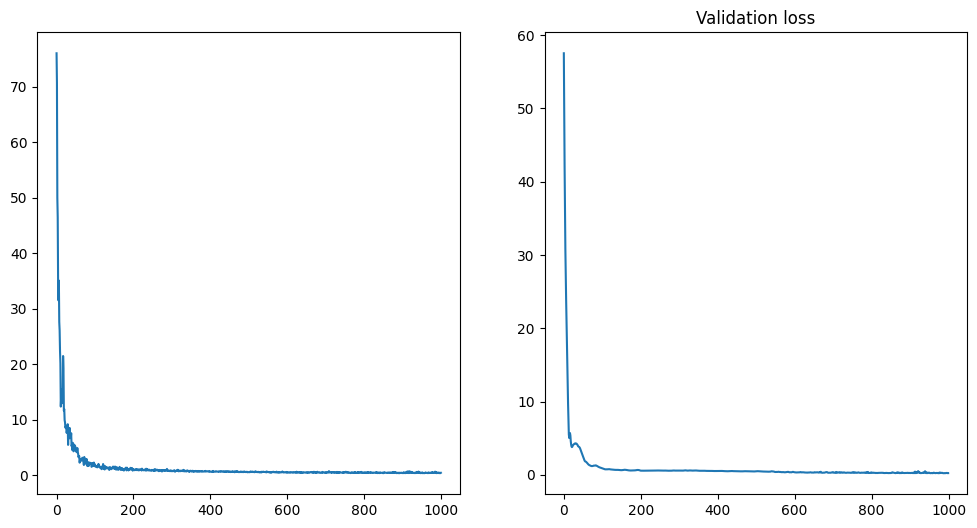

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(loss_train_list)
ax2.set_title('Training loss')
ax2.plot(loss_val_list)
ax2.set_title('Validation loss')
plt.show()

In [31]:
model.eval()
output = model(features, adj)
loss_test = F.nll_loss(output[idx_test], labels[idx_test])
idx_test_preds = output[idx_test].max(1)[1].type_as(labels)
acc_test = accuracy(output[idx_test], labels[idx_test])
print(f'Test Loss: {loss_test.item():.4f} | Test Acc: {acc_test.item():.4f}')

Test Loss: 0.3336 | Test Acc: 0.8333


In [32]:
torch.sum(labels[idx_test]!=idx_test_preds).item()

5

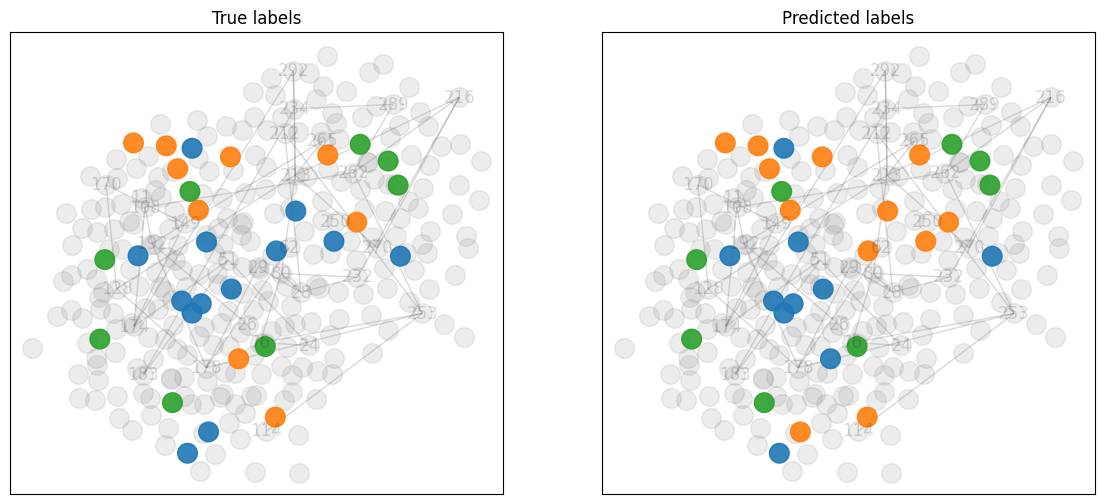

In [35]:
G1 = nx.from_numpy_array(adj.numpy())
node_pos=nx.spring_layout(G, seed=0)

idx_train_nodes = np.nonzero(idx_train.numpy())[0]
idx_val_nodes = np.nonzero(idx_val.numpy())[0]
idx_test_nodes = np.nonzero(idx_test.numpy())[0]

idx_train_graph = G.subgraph(idx_train_nodes.tolist())
idx_val_graph = G.subgraph(idx_val_nodes.tolist())

idx_test_graph = G.subgraph(idx_test_nodes.tolist())
idx_test_graph_colors_true = np.array(colors)[labels[idx_test]]
idx_test_graph_colors_preds = np.array(colors)[idx_test_preds]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.set_title('True labels')
nx.draw_networkx_nodes(idx_train_graph,
                       pos=node_pos,
                       node_size=200,
                       node_color='grey',
                       alpha=0.15,
                       ax=ax1)

nx.draw_networkx(idx_val_graph,
                 pos=node_pos,
                 node_size=200,
                 node_color='grey',
                 alpha=0.15,
                 ax=ax1)

nx.draw_networkx_nodes(idx_test_graph,
                       pos=node_pos,
                       node_size=200,
                       node_color=idx_test_graph_colors_true,
                       alpha=0.9,
                       ax=ax1)

ax2.set_title('Predicted labels')
nx.draw_networkx_nodes(idx_train_graph,
                      pos=node_pos,
                      node_size=200,
                      node_color='grey',
                      alpha=0.15,
                      ax=ax2)

nx.draw_networkx(idx_val_graph,
                 pos=node_pos,
                 node_size=200,
                 node_color='grey',
                 alpha=0.15,
                 ax=ax2)

nx.draw_networkx_nodes(idx_test_graph,
                       pos=node_pos,
                       node_size=200,
                       node_color=idx_test_graph_colors_preds,
                       alpha=0.9,
                       ax=ax2)
plt.show()

In [36]:
model

GCN(
  (gc1): GraphConvolution(10->3)
  (gc2): GraphConvolution(3->3)
)

In [37]:
embeddings= F.relu(model.gc1(features,adj)).detach().numpy()
embeddings.shape

(300, 3)

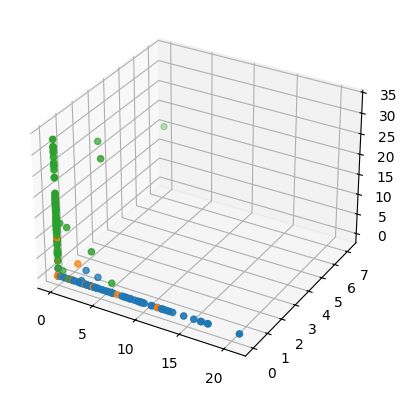

In [38]:
fig=plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(embeddings[:,0], embeddings[:,1], embeddings[:,2], c=y_colors)
plt.show()